In [1]:
cd ..

/gpfs01/bethge/home/mkuemmerer/Documents/Uni/Bethge/Saliency/pysaliency


In [2]:
from __future__ import print_function

In [3]:
%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import os

import numpy as np

In [6]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')

Pysaliency
==========

Saliency Map Models
----------------------

`pysaliency` comes with a variety of features to evaluate saliency map models. This notebooks demonstrates these features.

First we load the MIT1003 dataset:

In [7]:
import pysaliency
import pysaliency.external_datasets

data_location = 'test_datasets'

mit_stimuli, mit_fixations = pysaliency.external_datasets.get_mit1003(location=data_location)

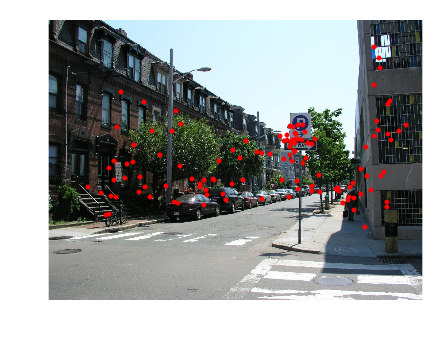

In [8]:
index = 0
plt.imshow(mit_stimuli.stimuli[index])
f = mit_fixations[mit_fixations.n == index]
plt.scatter(f.x, f.y, color='r')
_ = plt.axis('off')

As some evaluation methods can take quite a long time to run, we prepare a smaller dataset consisting of only the first 10 stimuli:

In [9]:
cutoff = 10
short_stimuli = pysaliency.FileStimuli(filenames=mit_stimuli.filenames[:cutoff])
short_fixations = mit_fixations[mit_fixations.n < cutoff]

We will use the saliency model *AIM* by Bruce and Tsotos

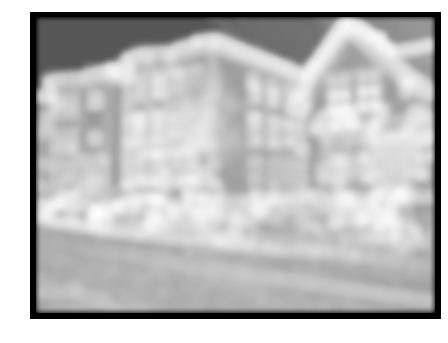

In [10]:
aim = pysaliency.AIM(location='test_models', cache_location=os.path.join('model_caches', 'AIM'))
smap = aim.saliency_map(mit_stimuli[10])
plt.imshow(-smap)
plt.axis('off');

Evaluating Saliency Map Models
=================

Pysaliency is able to use a variety of evaluation methods to evaluate saliency models, both saliency map based models and probabilistic models. Here we demonstrate the evaluation of saliency map models

We can evaluate area under the curve with respect to a uniform nonfixation distribution:

In [11]:
aim.AUC(short_stimuli, short_fixations, nonfixations='uniform', verbose=True)

1102 (100.0%)


0.76073938359366133

By setting `nonfixations='shuffled'` the fixations from all other stimuli will be used:

In [12]:
aim.AUC(short_stimuli, short_fixations, nonfixations='shuffled', verbose=True)

1102 (100.0%)


0.64568979694334194

Also, you can hand over arbitrary `Fixations` instances as nonfixations:

In [13]:
aim.AUC(short_stimuli, short_fixations, nonfixations=short_fixations, verbose=True)

1102 (100.0%)


0.5

Another popular saliency metric is the *fixation based KL-Divergence* as introduced by Itti. Usually it is just called *KL-Divergence* which creates confusion as there is also another completely different saliency metric called KL-Divergence (here called *image based KL-Divergence*, see below).

As AUC, fixation based KL-Divergence needs a nonfixation distribution to compare to. Again, you can use `uniform`, `shuffled` or any `Fixations` instance for this.

In [14]:
perf = aim.fixation_based_KL_divergence(short_stimuli, short_fixations, nonfixations='uniform')
print('Fixation based KL-divergence wrt. uniform nonfixations: {:.02f}'.format(perf))

Fixation based KL-divergence wrt. uniform nonfixations: 0.44


In [15]:
perf = aim.fixation_based_KL_divergence(short_stimuli, short_fixations, nonfixations='shuffled')
print('Fixation based KL-divergence wrt. shuffled nonfixations: {:.02f}'.format(perf))

Fixation based KL-divergence wrt. shuffled nonfixations: 0.14


In [16]:
perf = aim.fixation_based_KL_divergence(short_stimuli, short_fixations, nonfixations=short_fixations)
print('Fixation based KL-divergence wrt. identical nonfixations: {:.02f}'.format(perf))

Fixation based KL-divergence wrt. identical nonfixations: 0.00


The *image based KL-Divergence* can be calculated, too. Unlike all previous metrics, it needs a gold standard to compare to. Here we use a fixation map that has been blured with a Gaussian kernel of size 30px. Often a kernel size of one degree of visual angle is used.

In [17]:
gold_standard = pysaliency.FixationMap(short_stimuli, short_fixations, kernel_size=30)
perf = aim.image_based_kl_divergence(short_stimuli, gold_standard)
print("Image based KL-divergence: {} bit".format(perf / np.log(2)))

Image based KL-divergence: 1.78544965861 bit


The gold standard is assumed to be the real distribution, hence it has a image based KL divergence of zero:

In [18]:
gold_standard.image_based_kl_divergence(short_stimuli, gold_standard, minimum_value=1e-20)

0.0

To implement you own saliency map model, inherit from `pysaliency.SaliencyMapModel` and implement the `_saliency_map` method.

In [19]:
class MySaliencyMapModel(pysaliency.SaliencyMapModel):
    def _saliency_map(self, stimulus):
        return np.ones((stimulus.shape[0], stimulus.shape[1]))

In [20]:
msmm = MySaliencyMapModel()